# Spectral Clustering for Identifying Large-Scale Neuron Connectivity

##### Jackson Cornell

Brain-Computer Interfaces (BCI) are becoming increasingly widespread and complex. Algorithms must keep up with this increasing complexity and be able to process and identify patterns in large sets of data being streamed by thousands of electrodes. In this paper, I model the data as a large graph, and apply spectral clustering algorithms to identify connectivity between neurons of the brain.

In [1]:
from numpy import linalg as LA
from pywt import dwt
from scipy.spatial.distance import cdist
from sklearn import cluster
from sklearn import metrics
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

## I. Neuronal Simulations

We will model the neruon populations as point processes with inhibatory and exhitatory connections.

In [2]:
# Weight function for inter-neuron connections
def neuron_weight_func(F, M, A, B, t) :
    return A * np.sin(F * np.pi * t / M) * np.exp(-B * t / M)

# Autoinhibatory weight function for neuron
def autoinhibatory(M, t) :
    A = -2
    F = 3000
    B = 3000
    return neuron_weight_func(F, M, A, B, t)

# Crossexcitatory weight function for neurons
def excitatory(M, t) :
    A = 2.5
    F = 4000
    B = 3000
    return neuron_weight_func(F, M, A, B, t)

# Crossinhibatory weight functions for neurons
def crossinhibatory(M, t) :
    A = -3
    F = 3000
    B = 3000
    return neuron_weight_func(F, M, A, B, t)
    
# Generate spike train for neuron
def generate_spiketrain(lam_p, M) :
    rand_vect = np.random.rand(M)
    return lam_p > rand_vect

def interspike_interval(s_p, delta) :
    N = np.shape(s_p)
    # find indices of 1
    spike_times = delta * np.where(s_p == 1)[0]
    intervals = spike_times[2:] - spike_times[1:-1]
    return intervals

# Geneate cluster of connected neurons
def generate_cluster(K, N, Mpp, Mpq, delta, beta) :
    s_p = np.zeros((K, N))
    for p in range(K) :
        # generate intensity function without driving neuron
        if (p == 0) :
            lam_p = np.exp(beta + np.sum([autoinhibatory(Mpp, m*delta) for m in range(N)])) * np.ones(N)
            plt.plot(delta*lam_p[:500])
            plt.title("Neuron {}".format(p))
            plt.show()
            s_p[p, :] = generate_spiketrain(delta*lam_p, N)
        # generate intensity function with driving neurons
        else :
            # initialize neuron firing intensity
            lam_p = np.zeros(N)
            for t in range(N) :
                # find starting index
                if (t < Mpq) :
                    end = t
                else :
                    end = Mpq
                # sum over coupling neurons
                coeff = np.sum([(excitatory(Mpq, m*delta) * s_p[p-1, t - m]) for m in range(0, end)])
                coeff += np.sum([autoinhibatory(Mpp, m*delta) for m in range(N)])
                lam_p[t] = np.exp(beta + coeff)
            # compute neurons spike train
            plt.plot(delta*lam_p[:500])
            plt.title("Neuron {}".format(p))
            plt.show()
            s_p[p, :] = generate_spiketrain(delta*lam_p, N)
    return s_p

# Generate several clusters of neurons
def generate_multiple_clusters(num_clusters, K, N, Mpp, Mpq, delta, beta) :
    s_p = np.zeros((num_clusters*K, N))
    for i in range(num_clusters) :
        np.random.RandomState(seed=i+1)
        s_i = generate_cluster(K, N, Mpp + i*10, Mpq + i*10, delta, beta - i*0.1)
        s_p[(num_clusters*i):(num_clusters*(i+1)), :] = s_i
    return s_p

A demonstration of inter-neuron weight functions. These weight functions define the synaptic coupling of either two neurons, or a neuron with itself. These can either increase or decrease the probability of firing. They are defined by the value $M$, wherein larger values of $M$ result in a longer window of coupling, and vice verse for smaller values.

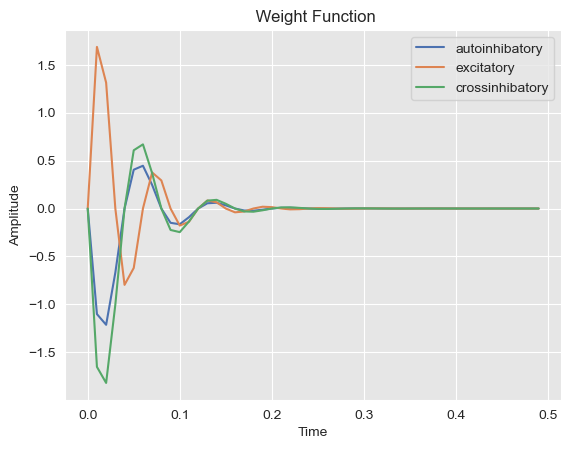

In [3]:
# simulate weight function
M = 120
N = 100
delta = 0.01
t = delta * np.arange(0, N)
x_autoin = autoinhibatory(M, t)
x_ex = excitatory(M, t)
x_crossin = crossinhibatory(M, t)

# display output
plt.plot(t[:50], x_autoin[:50], label='autoinhibatory')
plt.plot(t[:50], x_ex[:50], label='excitatory')
plt.plot(t[:50], x_crossin[:50], label='crossinhibatory')
plt.title(" Weight Function")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

We will now simulate the firing of a single neuron, which will act as the "source" neuron for our population.

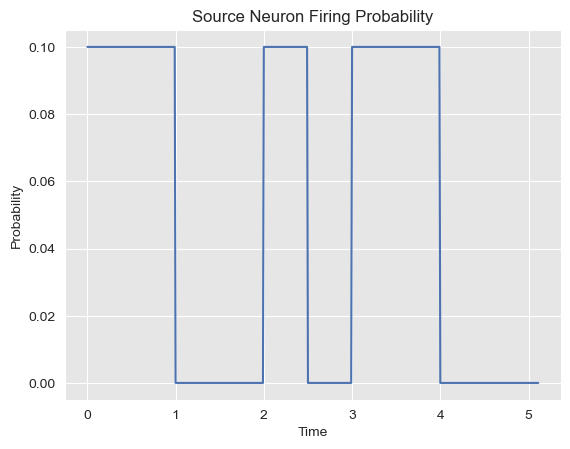

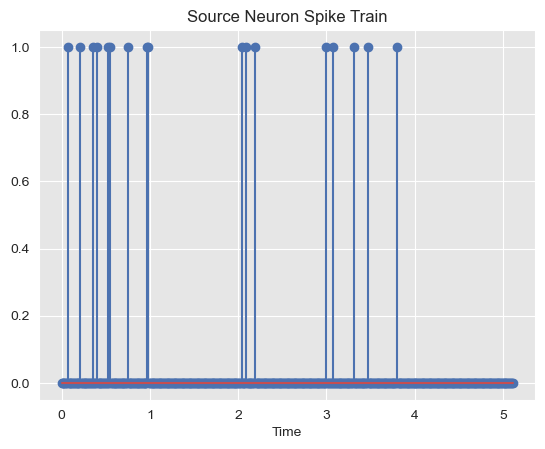

In [4]:
# neuron parameters
p_firing = 0.1
beta = np.log(p_firing)
delta = 0.01  # time bin length
N = 512  # number of bins
t = delta * np.arange(0, 512)
firing_int = np.concatenate((np.arange(0, 100),
                             np.arange(200, 250),
                             np.arange(300, 400)))  # intervals of firing

# simulate probability function
lam_p = np.zeros(N)
lam_p[firing_int] = np.exp(beta)

# generate probabilistic spike train
spike_train = generate_spiketrain(lam_p, N)

# display results
plt.plot(t, lam_p)
plt.title("Source Neuron Firing Probability")
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()

plt.stem(t, spike_train)
plt.title("Source Neuron Spike Train")
plt.xlabel('Time')
plt.show()

Now to simulate a train of neurons.

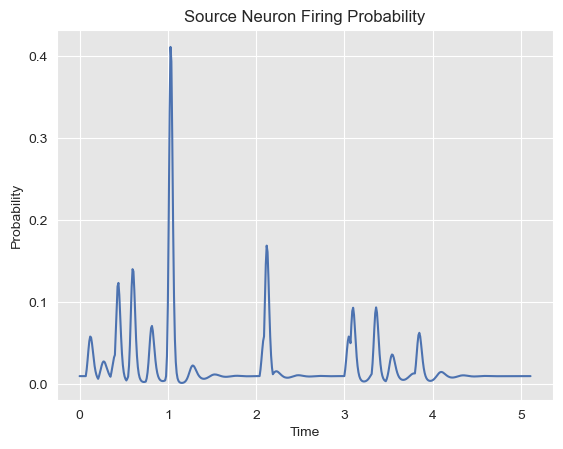

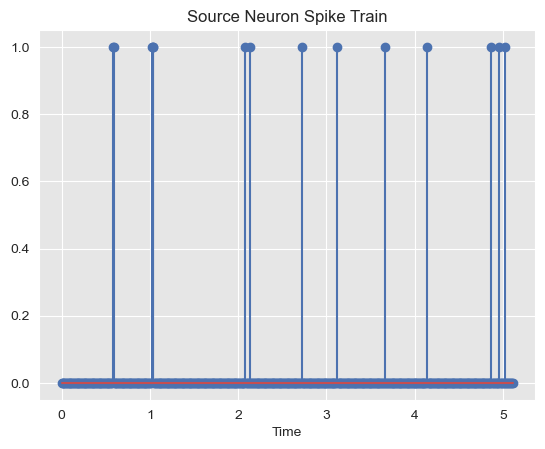

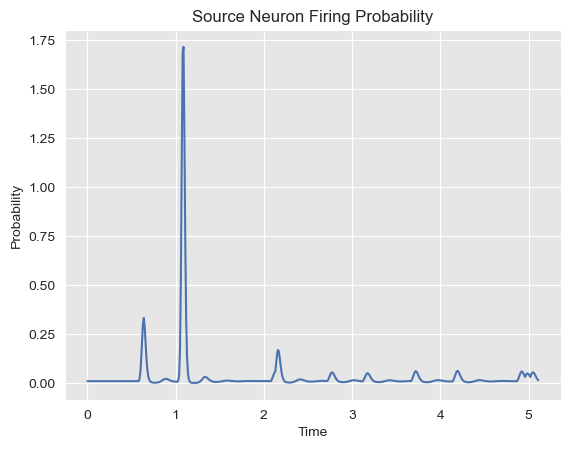

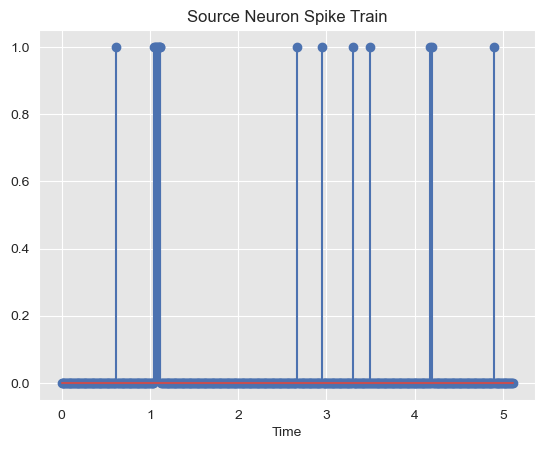

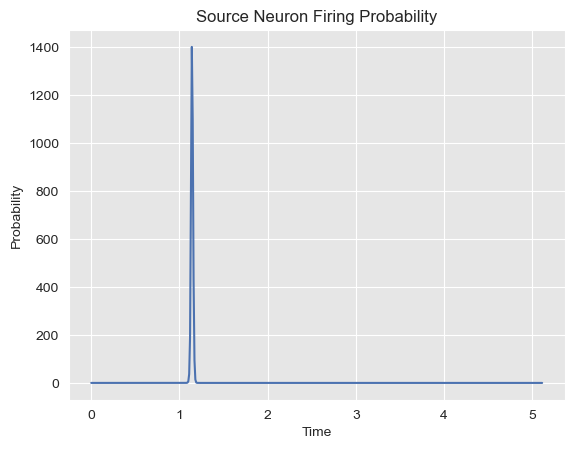

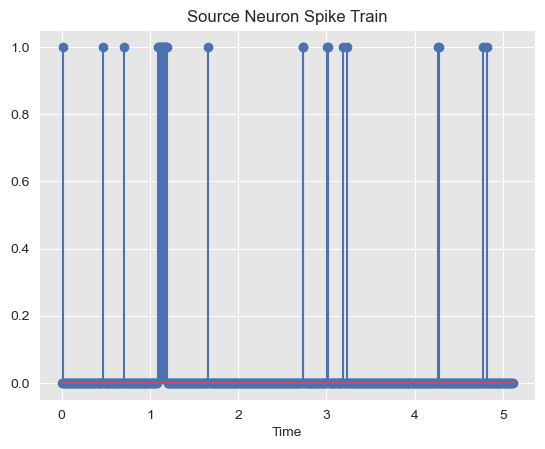

In [5]:
# neuron parameters
p_firing = 0.0001
beta = np.log(p_firing)
Mpq = 500  # exhitatory timescale
K = 4  # cluster count
lam_p = np.zeros((K, N))  # firing probability matrix
s_p1 = np.zeros((K, N))  # spike train matrix
s_p1[0, :] = spike_train

# simulate neurons
for p in np.arange(1, K) :
    coeff = np.zeros(N) #beta * np.ones(N)
    for n in range(N) :
        # check for spike
        if (s_p1[p-1, n] == 1) :
            # add excitatory weight function for spike
            interval = np.arange(n, N)
            coeff[interval] += excitatory(Mpq, delta * (interval - n))
    # construct probability
    lam_p[p, :] = np.exp(coeff)
    # genertae spike train
    s_p1[p, :] = generate_spiketrain(delta * lam_p[p, :], N)
    
# display results
for k in np.arange(1, K) :
    plt.plot(t, delta * lam_p[k, :])
    plt.title("Source Neuron Firing Probability")
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.show()

    plt.stem(t, s_p1[k, :])
    plt.title("Source Neuron Spike Train")
    plt.xlabel('Time')
    plt.show()

Repeat the above process for a second population of neurons. Use different dynamics to simulate seperate functionality.

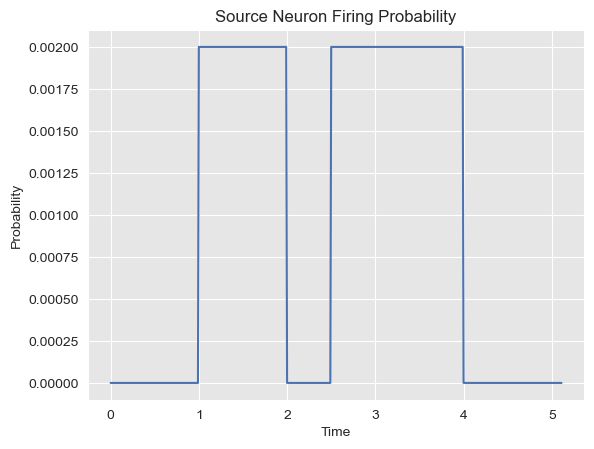

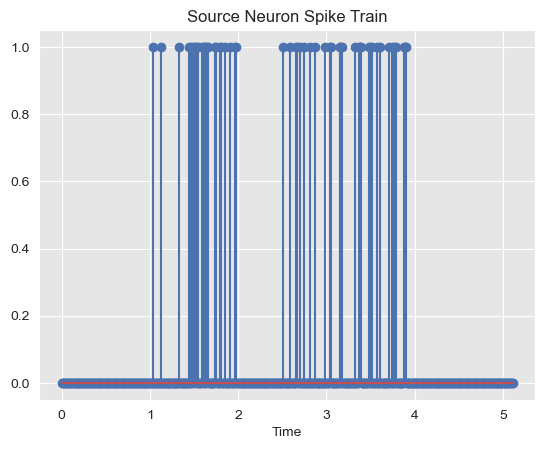

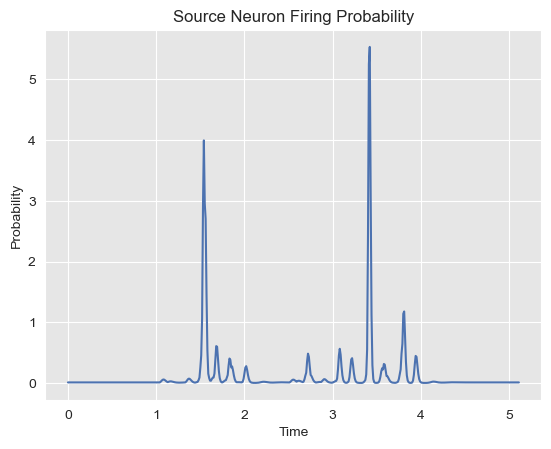

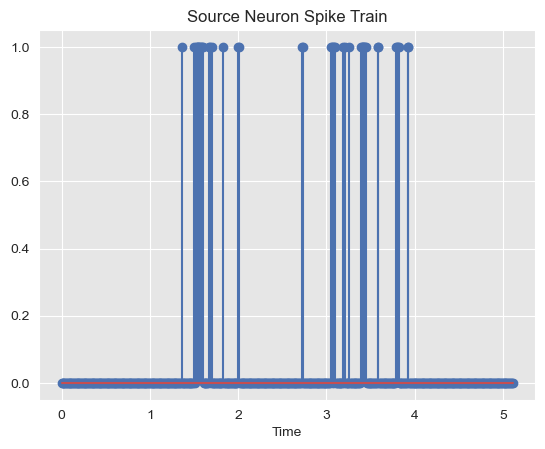

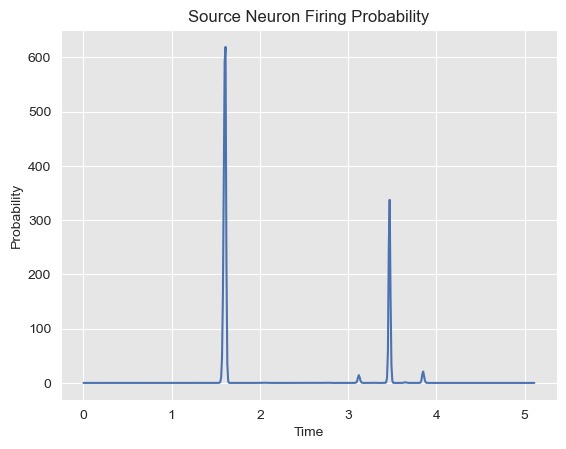

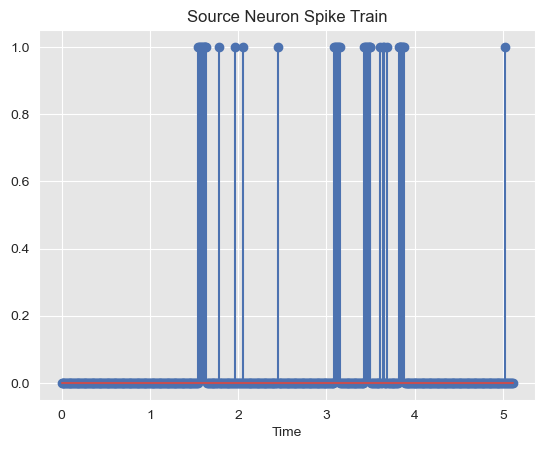

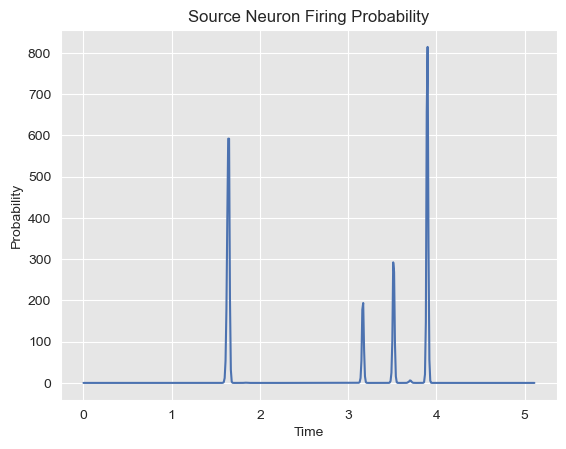

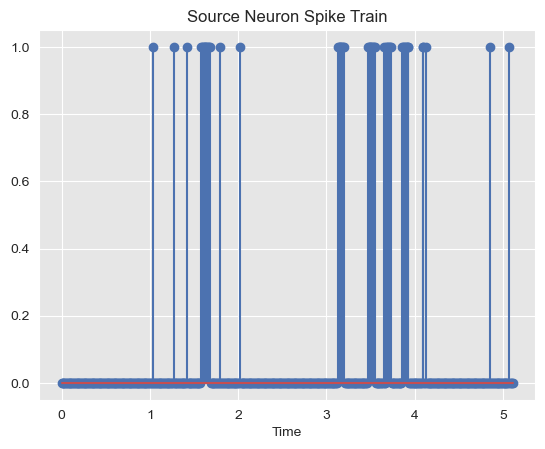

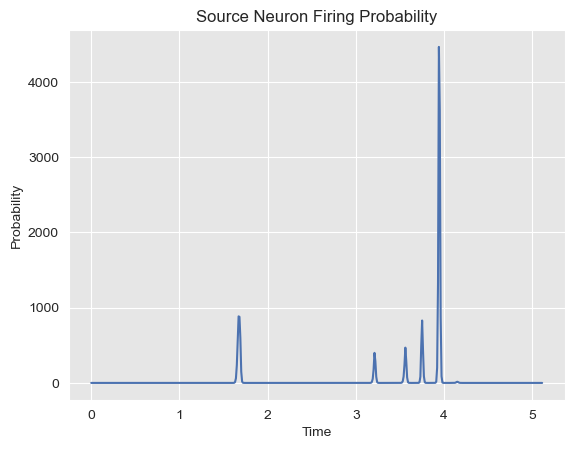

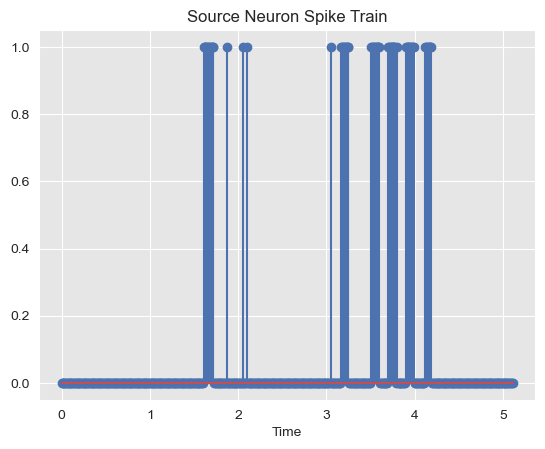

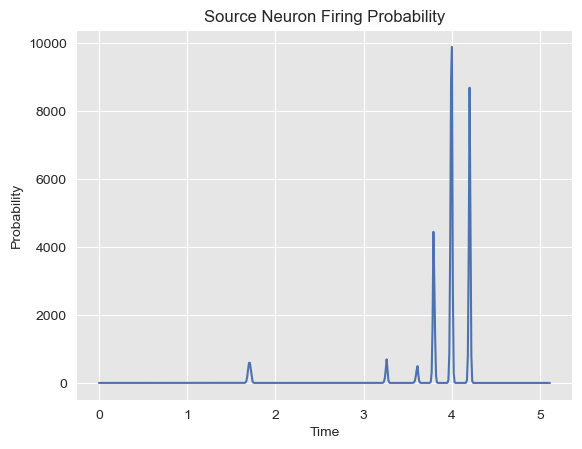

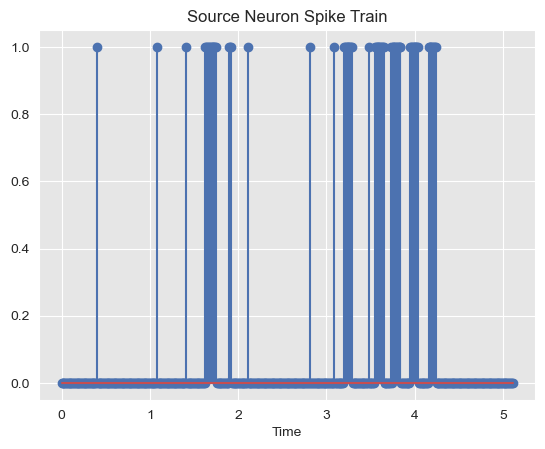

In [6]:
# neuron parameters
p_firing = 0.2
beta_src = np.log(p_firing)
delta = 0.01
N = 512
t = delta * np.arange(0, 512)
firing_int = np.concatenate((np.arange(100, 200),
                             np.arange(250, 400)))

p_firing = 0.00001
beta = np.log(p_firing)
Mpq = 400
K2 = 6
lam_p2 = np.zeros((K2, N))
s_p2 = np.zeros((K2, N))

# simulate source neuron
lam_p2[0, firing_int] = np.exp(beta_src)
s_p2[0, :] = generate_spiketrain(lam_p2[0, :], N)

# simulate rest of population
for p in np.arange(1, K2) :
    coeff = np.zeros(N)
    for n in range(N) :
        if (s_p2[p-1, n] == 1) :
            interval = np.arange(n, N)
            coeff[interval] += excitatory(Mpq, delta * (interval - n))
    lam_p2[p, :] = np.exp(coeff)
    s_p2[p, :] = generate_spiketrain(delta * lam_p2[p, :], N)
    
# display results
for k in range(K2) :
    plt.plot(t, delta * lam_p2[k, :])
    plt.title("Source Neuron Firing Probability")
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.show()

    plt.stem(t, s_p2[k, :])
    plt.title("Source Neuron Spike Train")
    plt.xlabel('Time')
    plt.show()

Combine the two spike trains into one for clustering.

[Text(0.5, 1.0, 'Spike Train')]

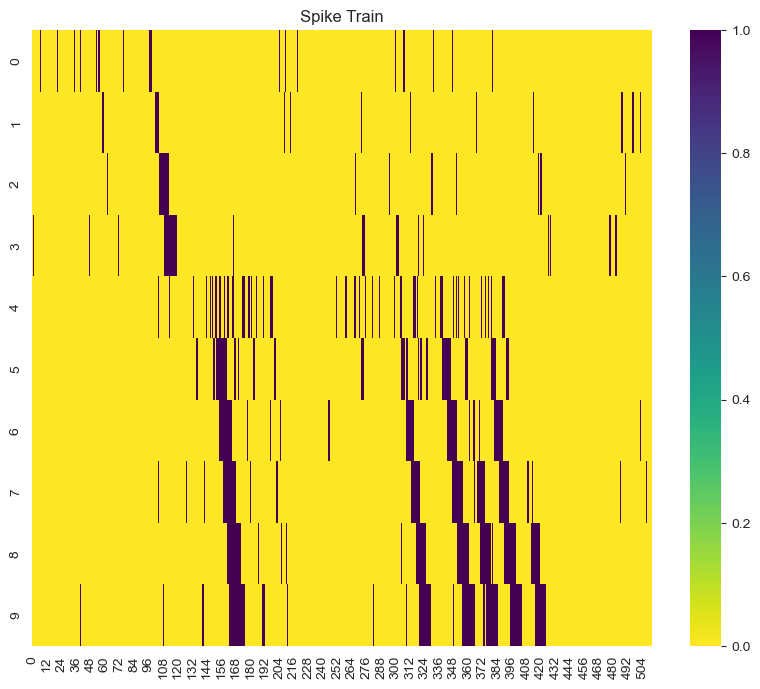

In [7]:
# combine populations
s_p = np.zeros((K + K2, N))
s_p[:K, :] = s_p1
s_p[K:, :] = s_p2

# display raster plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(s_p, ax=ax, cmap='viridis_r')
ax.set(title='Spike Train')

## II. Data Pre-Processing

In [8]:
# visualize first "count" wavelets in s_j
def visualize_wavelet(s_j, count=1) :
    J = len(s_j)
    for p in range(count) :
        coeffs = []
        for j in range(J) :
            W_j = s_j[j]
            coeffs.append(W_j[p, :])
        for i, ci in enumerate(coeffs):
            plt.imshow(ci.reshape(1, -1), extent=[0, 1000, i + 0.5, i + 1.5], cmap='inferno', aspect='auto', interpolation='nearest')
        plt.ylim(0.5, len(coeffs) + 0.5)
        plt.title('Wavelet Decomposition of Neuron {}'.format(p+1))
        plt.show()

# Construct Haar matrix for each time index 1,..,J
def haar_matrix(N, J):
    # assert N and j compatable
    assert (N & (N - 1) == 0) and N != 0
    assert (N / (2**J)) >= 1
    M = N
    W_arr = []
    # construct Haar matrices
    for j in range(J) :
        Nhalf = int(N / 2)
        W = np.zeros((N, M))
        K = 2**(j + 1)
        coeff = (np.sqrt(2) / 2)**(j + 1)
        for n in range(Nhalf) :
            for k in range(K) :
                # approximation coefficients
                W[n, K*n+k] = coeff
                # detail coefficients
                if (k < (K/2)) :
                    W[n + Nhalf, K*n + k] = coeff
                else :
                    W[n + Nhalf, K*n + k] = -coeff
        # update variables
        W_arr.append(W)
        N = Nhalf
    # save approximation sub matrix
    return W_arr

# Gaussian kernel of 
def gaussian_kernel(x, size) :
    return np.exp(-x / (2 * size**2))

def spike_train_to_times(s_p, delta) :
    P, N = np.shape(s_p)
    times = np.zeros((P, N))
    for p in range(P) :
        spike_times = delta * np.asarray(s_p[p, :] == 1).nonzero()[0]
        times[p, :spike_times.size] = spike_times
    return times
        
def MemorylessCrossIntensityKernel(s_p, delta, kernel_size) :
    # get time instances of spike trains
    t = spike_train_to_times(s_p, delta)
    # map to RKHS
    D = euclidean_distances(t, t, squared=True)
    print(np.shape(t), np.shape(D))
    Iss = gaussian_kernel(D, kernel_size)
    return Iss

# Construct wavelet representation of spike train
def SpikeTrainWaveletDec(s_p, J=2) :
    s_j = []
    P, N = np.shape(s_p)
    # if N not power of two, truncate
    if (N & (N - 1) != 0) :
        pwr = int(np.log2(N))
        N = 2**pwr
        s_p = s_p[:, :N]
    # get wavelet coefficients
    W_arr = haar_matrix(N, J)
    # iterate through each time index
    for j in range(J) :
        W = W_arr[j]
        s_j.append(s_p @ W.T)
    return s_j

# Find P^2 x J covariance matrix of each wavelet time index matrix
def WaveletCovariation(s_j) :
    J = len(s_j)
    P = np.shape(s_j[0])[0]
    R = np.zeros((P**2, J))
    # iterate through each time index
    for j in range(J) :
        # get wavelet coefficients
        W_j = s_j[j]
        # get covariance matrix
        sigma = np.cov(W_j)
        # vectorize covariance matrix
        sigma_vec = np.reshape(sigma, P**2)
        # add to R
        R[:, j] = sigma_vec
    return R

# create similarity matrix of neurons
def SimilarityMatrix(R, Q) :
    P = int(np.sqrt(np.shape(R)[0]))
    W = np.zeros((P, P))
    # perform SVD of covariation matrix R
    U, S, V_T = LA.svd(R, full_matrices=True)
    # get first Q modes of SVD
    R_Q = U[:, :Q] @ np.diag(S[:Q]) @ V_T[:Q, :Q]
    # iterate through each Q
    for q in range(Q) :
        R_q = R_Q[:, q]
        # de-vectorize
        W_q = np.reshape(R_q, (P, P))
        W += W_q
    return W

# create adjacency matrix of similarity between neurons spike trains
def SimilarityFromSpikeTrain(s_p, J, Q) :
    # wavelet decomposition of spike train
    s_j = SpikeTrainWaveletDec(s_p, J)
    # get covariance matrix from s_j
    R = WaveletCovariation(s_j)
    # return similarity matrix from R
    return SimilarityMatrix(R, Q)

We will first do a wavelet decomposition of the spike train data.

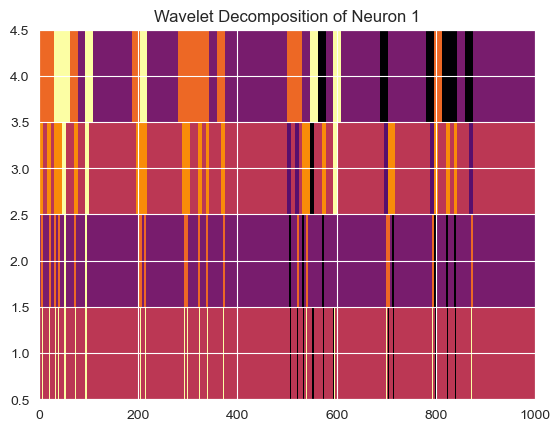

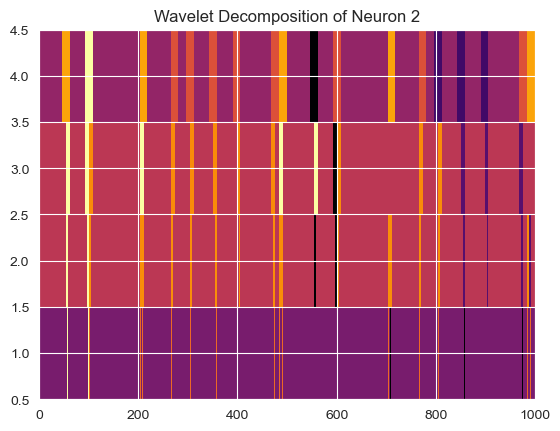

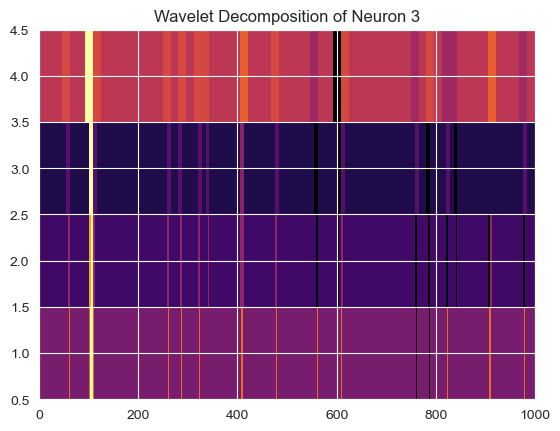

In [9]:
# wavelet decomposition
J = 4
s_j = SpikeTrainWaveletDec(s_p, J)

# display results
visualize_wavelet(s_j, count=3)

We will then compute a series of $J$ correlation matrices.

In [10]:
R = WaveletCovariation(s_j)

Singular Value Decomposition (SVD) is then used to construct a $P \times P$ similarity matrix, which will represent the pairwise similarity of neurons.

(10, 512) (10, 10)


[Text(0.5, 1.0, 'Spike Train Adjacency Matrix')]

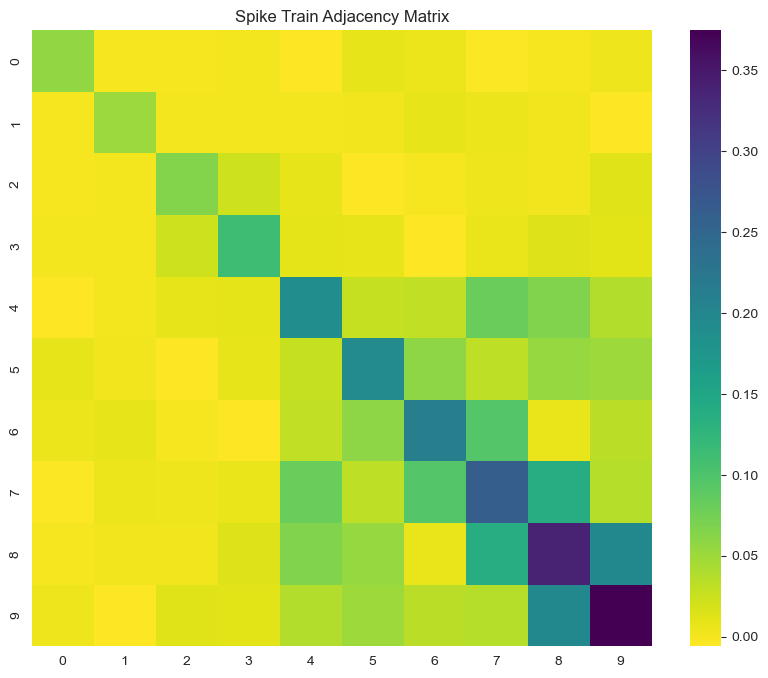

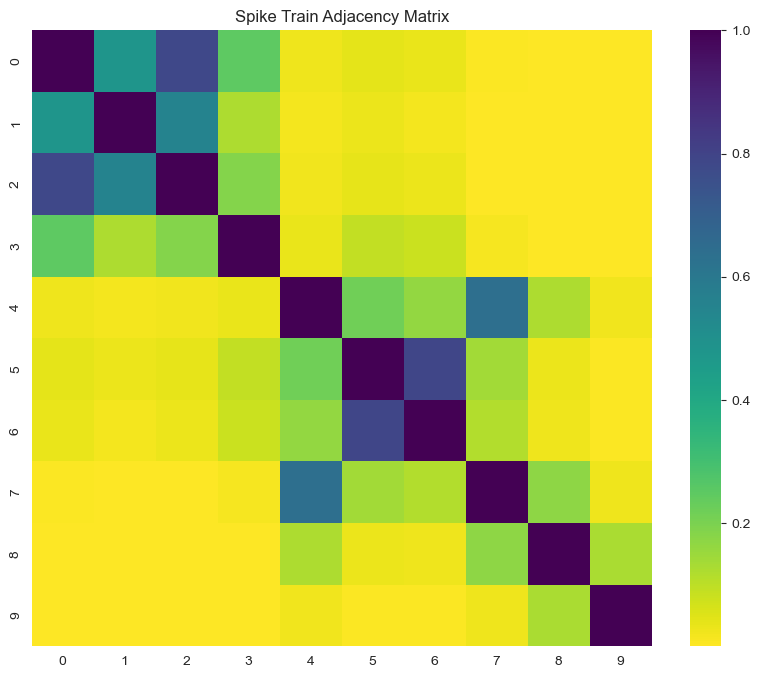

In [11]:
# construct adjacency matrix
Q = 2
W_neurons = SimilarityMatrix(R, Q)

# construct adjacency matrix using kernel method
kernel_size = 7
Iss = MemorylessCrossIntensityKernel(s_p, delta, kernel_size)

# display results
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(W_neurons, ax=ax, cmap='viridis_r')
ax.set(title='Spike Train Adjacency Matrix')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(Iss, ax=ax, cmap='viridis_r')
ax.set(title='Spike Train Adjacency Matrix')

## III. Spectral Clustering

In [12]:
# Returns euclidean distance between two points
def euclidean_distance(x, y):
    xSumSquare = np.sum(np.square(x), axis=1);
    ySumSquare = np.sum(np.square(y), axis=1);
    mul = np.dot(x, y.T);
    dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
    return dists

# Initializes location of clusters
def init_centroids(X, K) :
    row, col = X.shape
    centroids = np.empty([K, col])
    for i in range(K):
        randIndex = np.random.randint(row)
        centroids[i] = X[randIndex]
    return centroids

# Updates the clusters each data point assigned to
def update_assignment(centers, X):
    row, col = X.shape
    cluster_idx = np.empty([row])
    distances = euclidean_distance(X, centers)
    cluster_idx = np.argmin(distances, axis=1)
    return cluster_idx

# Updates location of centroids based on new cluster assignments
def update_centroids(prev_centroids, cluster_idx, X):
    K, D = prev_centroids.shape
    centroids = np.empty(prev_centroids.shape)
    for i in range(K):
        centroids[i] = np.mean(X[cluster_idx == i], axis = 0)
    return centroids

# Loss function of K-means
def loss(centroids, cluster_idx, X):
    dists = euclidean_distance(X, centroids)
    N, D = X.shape
    loss = 0.0
    for i in range(N):
        loss = loss + np.square(dists[i][cluster_idx[i]])  
    return loss

# Given adjacency matrix W, return diagonal edge matrix D
def get_D(W, verbose=True) :
    # count number of edges from each vertex
    edge_cnt = []
    for i in range(np.shape(W)[0]) :
        #vertex = np.asarray(W[i, :])
        #edge_cnt.append((vertex != 0).sum())
        edge_cnt.append(np.sum(W[i, :]))
    # diaganolize vector
    D = np.diag(edge_cnt)
    # print results
    if (verbose == True) :
        print("Edge Matrix D of size", np.shape(D), ":\n", pd.DataFrame(D), "\n")
    return D
    
# Given adjacency matrix W, return Laplacian matrix L
def get_L(W, verbose=True) :
    # construct edge matrix
    D = get_D(W, verbose=verbose)
    # construct Laplacian
    L = D - W
    # print results
    if (verbose == True) :
        print("Laplacian L of size", np.shape(L), ":\n", pd.DataFrame(L), "\n")
    return L
    
# Given adjacency matrix W, return symmetric Laplacian matrix Lsym
def get_Lsym(W, verbose=True) :
    # construct edge matrix
    D = get_D(W, verbose=verbose)
    # take negative square root
    eigvals, eigvects = LA.eig(D)
    assert (eigvals >= 0).all()
    nsqrtD = eigvects @ np.diag(1 / np.sqrt(eigvals)) @ LA.inv(eigvects)
    # construct Laplacian
    Lsym = (nsqrtD @ W @ nsqrtD)
    # print results
    if (verbose == True) :
        print("Symmetric Laplacian L of size", np.shape(Lsym), ":\n", pd.DataFrame(Lsym), "\n")
    return Lsym

# Given Laplacian matrix Lsym and number of clusters K, return eigen matrix U and eigenvalues u
def get_U(Lsym, K, mode='max', verbose=True) :
    # compute eigenvalues
    eigenvals, eigenvects = LA.eig(Lsym)
    # sort results
    sorted_indices = np.argsort(eigenvals)
    sorted_eigenvals = np.real(eigenvals[sorted_indices])
    sorted_eigenvects = np.real(eigenvects[:, sorted_indices.squeeze()])
    # retrieve first K values
    if (mode == 'max') :
        u = sorted_eigenvals[-K:]
        U = sorted_eigenvects[:, -K:]
    elif (mode == 'min') :
        u = sorted_eigenvals[:K]
        U = sorted_eigenvects[:, :K] 
    else :
        raise Exception("Invalid mode")
    # print results
    if (verbose == True) :
        # print eigens
        print("L Eigenvalues:\n", pd.DataFrame(u), "\n")
        print("\nL Eigenvectors of size", np.shape(U), ":\n", pd.DataFrame(U), "\n")
    return u, U
    
# Given eigen matrix U of L, return normalized version T of eigen matrix U
def get_T(U, verbose=True) :
    # normalize along rows of eigen matrix U
    T = U
    for i in range(np.shape(U)[0]) :
        normal = LA.norm(U[i, :])
        T[i, :] = U[i, :] / normal
    # print results
    if (verbose == True) :
        print("Normalized Eigen Matrix T of size", np.shape(U), ":\n", pd.DataFrame(U), "\n")
    return U
    
# Given normalized eigen matrix T and number of clusters K, perform K-means clustering on embedded vector space
def K_Means(X, K, max_iter=100, threshold=1e-8, verbose=True) :
    centroids = init_centroids(X, K)
    cluster_idx = np.zeros(np.shape(X)[0])
    loss_trace = []
    current_loss = 1e10
    i = 0
    while (i < max_iter) and (current_loss > threshold) :
        cluster_idx = update_assignment(centroids, X)
        centroids = update_centroids(centroids, cluster_idx, X)
        current_loss = loss(centroids, cluster_idx, X)
        loss_trace.append(current_loss)
        i += 1
        # print results
        if (verbose == True) :
            print("Loss at iteration {}:".format(i), current_loss)
    return cluster_idx, centroids, loss_trace
    
# Given adjacency matrix W and number of clusters K, cluster graph using Normalized Spectral Clustering
def NormalizedSpectralClustering(W, K, verbose=True, metrics=False) :
    # construct Lapalacian matrix
    Lsym = get_Lsym(W, verbose=verbose)
    # construct eigen matrix
    u, U = get_U(Lsym, K, mode='max', verbose=verbose)
    # normalize eigen matrix
    T = get_T(U, verbose=verbose)
    # perform k-means clustering
    clusters, centroids, loss_trace = K_Means(T, K, verbose=verbose)
    # use skleanr k-means to find distortion
    if (metrics == True) :
        kmean = cluster.KMeans(n_clusters=k).fit(T)
        distortion = sum(np.min(cdist(T, kmean.cluster_centers_, 'euclidean'), axis=1)) / T.shape[0]
        inertia = kmean.inertia_
    else :
        distortion = -1
        inertia = -1
    return clusters, distortion, inertia

# Given adjacency matrix W and number of clusters K, cluster graph using traditional Spectral Clustering
def SpectralClustering(W, K, verbose=True, metrics=False) :
    # construct Lapalacian matrix
    L = get_L(W, verbose=verbose)
    # construct eigen matrix
    u, U = get_U(L, K, mode='min', verbose=verbose)
    # perform k-means clustering
    clusters, centroids, loss_trace = K_Means(U, K, verbose=verbose)
    # use skleanr k-means to find distortion
    if (metrics == True) :
        kmean = cluster.KMeans(n_clusters=k).fit(T)
        distortion = sum(np.min(cdist(T, kmean.cluster_centers_, 'euclidean'), axis=1)) / T.shape[0]
        inertia = kmean.inertia_
    else :
        distortion = -1
        inertia = -1
    return clusters, distortion, inertia

### a) Testing Algorithms

Produce input data for clustering applications

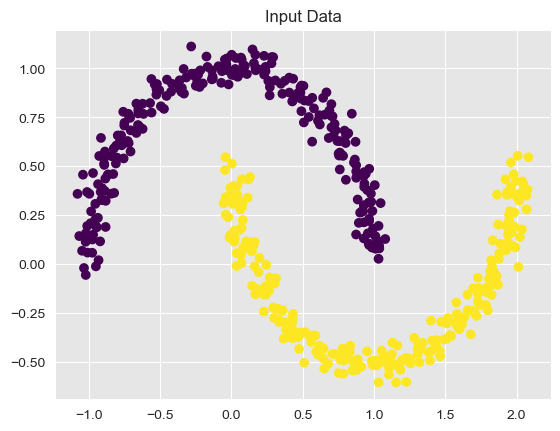

In [13]:
# Input data parameters
K = 3
n = 500
random_state = 42

# Crescent moons
X_mn, y = make_moons(n, noise=0.05, random_state=42)

# Two circles
#X_mn, y = make_circles(n_samples=n, factor=0.5, noise=0.05)

# Aniso blobs
# x, y = make_blobs(n_samples=n, random_state=random_state)
# transformation = [[0.6, -0.6], [-0.4, 0.8]]
# X_aniso = np.dot(x, transformation)
# aniso = (X_aniso, y)
# X_mn = np.array(X_aniso)

# plot the input data
data = pd.DataFrame(data={'x': X_mn[:, 0], 'y': X_mn[:, 1]})
fig, ax = plt.subplots()
ax.scatter(X_mn[:, 0], X_mn[:, 1], c=y, cmap='viridis')
ax.set(title='Input Data');

Retrieve adjacency graph representation of data

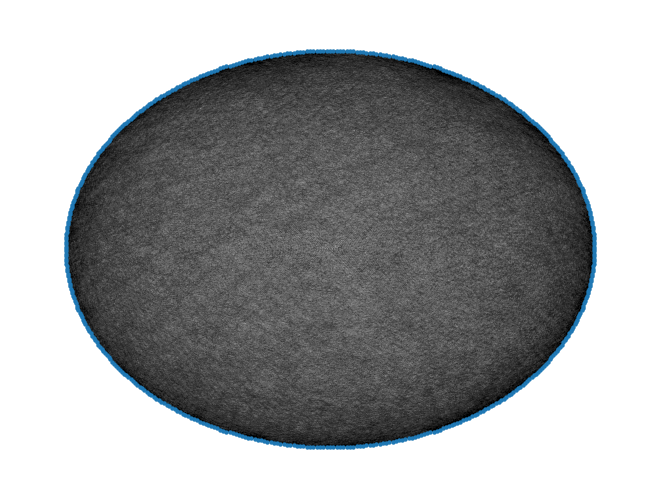

In [14]:
# Construct adjacency matrix from function
A = radius_neighbors_graph(X_mn, 0.8, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
#A = kneighbors_graph(X_mn, 5, mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
W = A.toarray()

# display results
G = nx.from_numpy_matrix(W)
nx.draw_circular(G, linewidths=0.01, width=0.01, node_size=10)

Construct Laplacian graph

In [15]:
# Construct Laplacian from scratch
L = get_Lsym(W, verbose=False)

# display results
print(pd.DataFrame(L))

          0         1         2         3         4         5         6    \
0    0.000000  0.000000  0.002697  0.000000  0.000000  0.006071  0.002905   
1    0.000000  0.000000  0.000000  0.000000  0.007560  0.000000  0.000000   
2    0.002697  0.000000  0.000000  0.000000  0.000000  0.003431  0.000795   
3    0.000000  0.000000  0.000000  0.000000  0.009462  0.000000  0.000000   
4    0.000000  0.007560  0.000000  0.009462  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.000000  0.007476  0.000000  0.008125  0.001364  0.000000  0.000000   
496  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
497  0.003410  0.000000  0.006241  0.000000  0.000000  0.009730  0.006180   
498  0.000000  0.000000  0.009443  0.000000  0.000000  0.006449  0.008315   
499  0.000000  0.008213  0.000000  0.008219  0.000998  0.000000  0.000000   

          7         8         9    ...       490  491       492       493  

 Display adjacency and Laplacian graph data

[Text(0.5, 1.0, 'Graph Laplacian')]

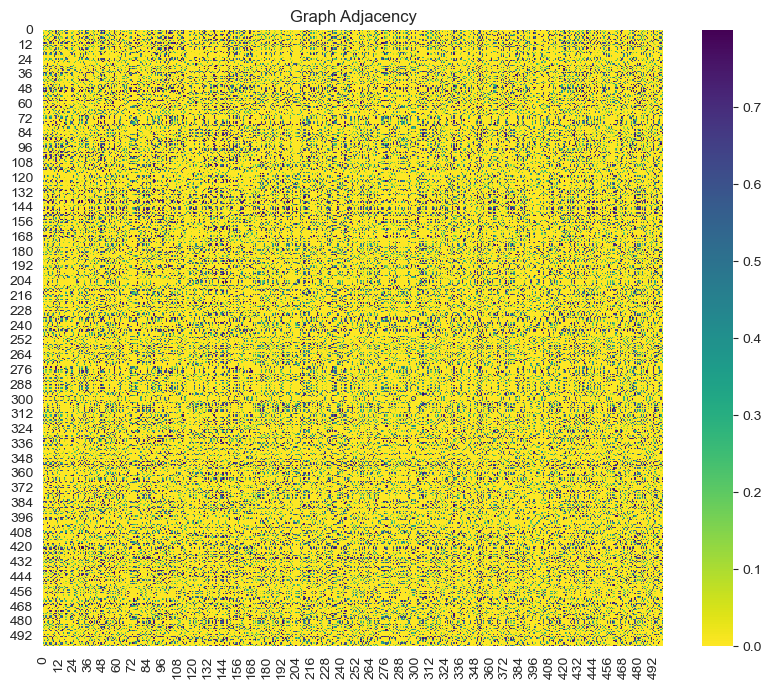

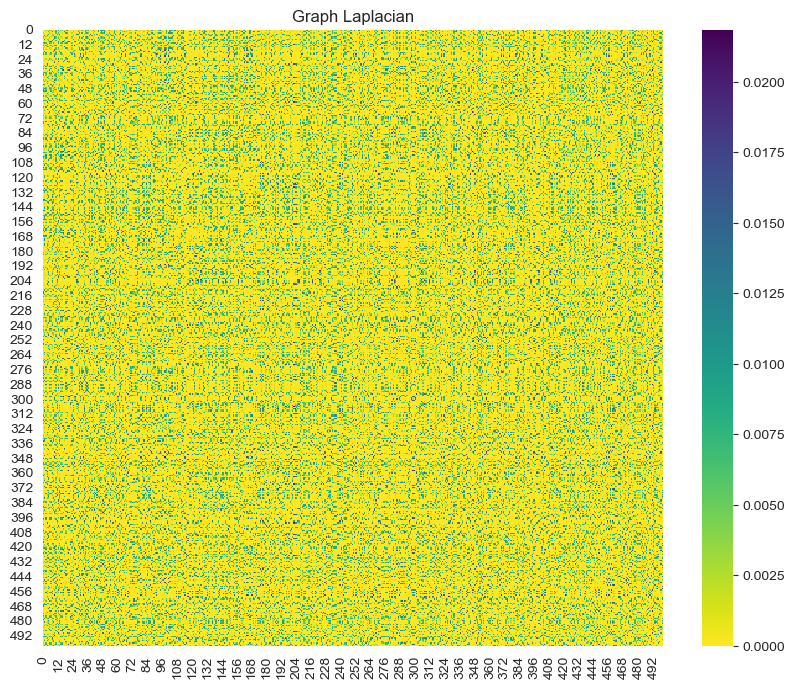

In [16]:
# display results
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(W, ax=ax, cmap='viridis_r')
ax.set(title='Graph Adjacency')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(L, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian')

Compute eigen values and vectors of Laplacian and plot results

            0         1         2
0   -0.361200  0.598337  0.715211
1   -0.629741 -0.278402  0.725202
2   -0.161631  0.683069  0.712245
3    0.261466 -0.736721  0.623601
4   -0.405954 -0.583247  0.703580
..        ...       ...       ...
495 -0.361298 -0.599594  0.714109
496 -0.714620 -0.158787  0.681253
497 -0.579541  0.458687  0.673601
498  0.544399  0.677994  0.493917
499 -0.324501 -0.619978  0.714371

[500 rows x 3 columns]
            0         1         2
0   -0.361200  0.598337  0.715211
1   -0.629741 -0.278402  0.725202
2   -0.161631  0.683069  0.712245
3    0.261466 -0.736721  0.623601
4   -0.405954 -0.583247  0.703580
..        ...       ...       ...
495 -0.361298 -0.599594  0.714109
496 -0.714620 -0.158787  0.681253
497 -0.579541  0.458687  0.673601
498  0.544399  0.677994  0.493917
499 -0.324501 -0.619978  0.714371

[500 rows x 3 columns]


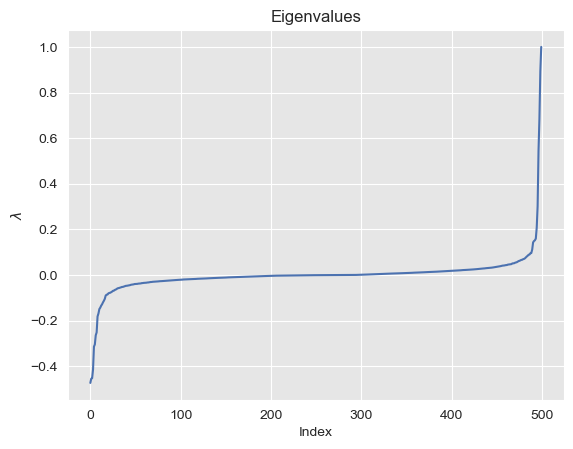

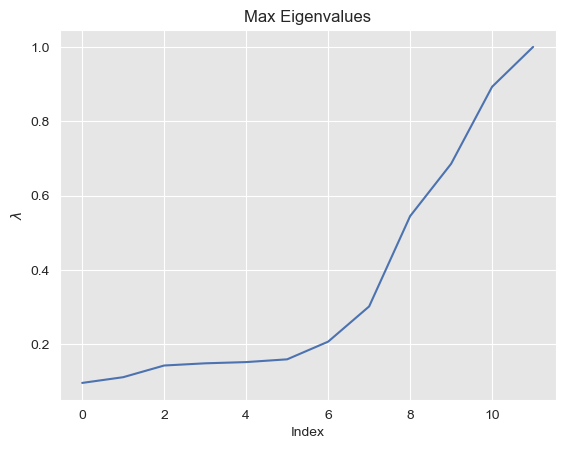

In [17]:
# Compute eigens
eigenvals, eigenvects = get_U(L, K, mode='max', verbose=False)
T = get_T(eigenvects, verbose=False)

# Convert to dataframe
proj_df = pd.DataFrame(T)
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

# display results
print(pd.DataFrame(eigenvects))
print(pd.DataFrame(T))

eigenvals, eigenvects = get_U(L, np.shape(L)[0], verbose=False, mode='max')
plt.figure()
plt.plot(eigenvals)
plt.xlabel('Index')
plt.ylabel('$\lambda$')
plt.title('Eigenvalues')
plt.show()
plt.figure()
plt.plot(eigenvals[-4*K:])
plt.xlabel('Index')
plt.ylabel('$\lambda$')
plt.title('Max Eigenvalues')
plt.show()

Perform clustering

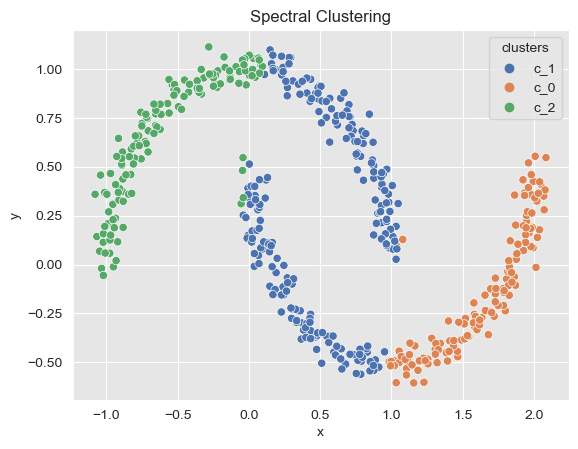

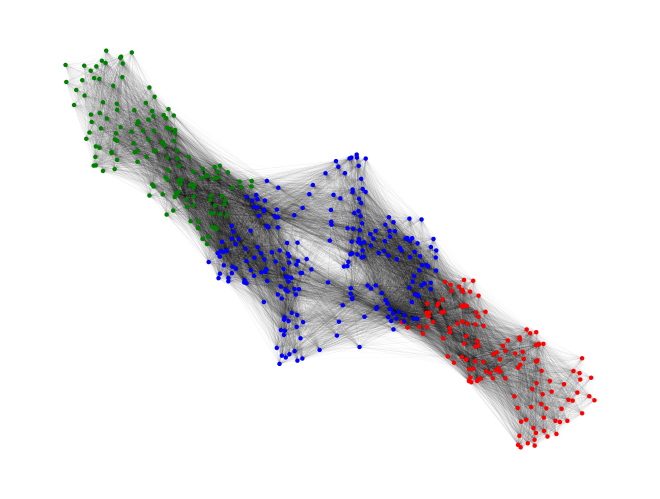

In [18]:
# Perform spectral clustering using built function
clusters, _, _ = K_Means(T, K, max_iter=100, threshold=0.5, verbose=False)

# display results
data['clusters'] = ['c_' + str(c) for c in clusters]
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data, hue='clusters', ax=ax)
ax.set(title='Spectral Clustering');
plt.show()

colors = []
for c in clusters :
    if c == 0 :
        colors.append('red')
    elif c == 1 :
        colors.append('blue')
    else :
        colors.append('green')
nx.draw(G, linewidths=0.01, width=0.01, node_size=10, node_color=colors)

### b) Use algorithms on simulated neuronal data 

Use normalized spectral clustering to cluster the neuron populations.

Rand Score: 0.10256410256410256
Mutual Info Score: 0.06392640952454082


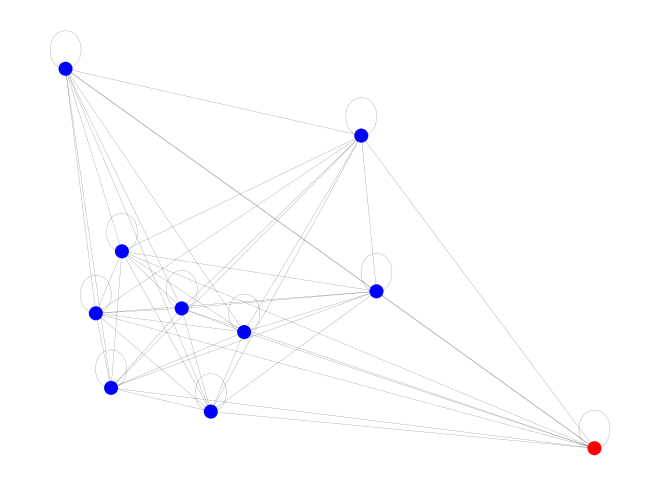

In [19]:
# spectral clustering
K = 2
clusters, _, _ = NormalizedSpectralClustering(W_neurons, K, verbose=False)

# convert adjacency matrix into graph
G = nx.from_numpy_matrix(W_neurons)

# display results
colors = []
for c in clusters :
    if c == 0 :
        colors.append('red')
    elif c == 1 :
        colors.append('blue')
nx.draw(G, linewidths=0.1, width=0.1, node_size=100, node_color=colors)

# check if clustering correct
true_labels = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
print("Rand Score:", metrics.adjusted_rand_score(true_labels, clusters))
print("Mutual Info Score:", metrics.adjusted_mutual_info_score(true_labels, clusters))
#print("Silhouette Score:", metrics.silhouette_score(W_neurons, clusters, metric="precomputed"))

Use normalized spectral clustering in conjunction with kernel methods to cluster the neuron populations.

Rand Score: 1.0
Mutual Info Score: 1.0


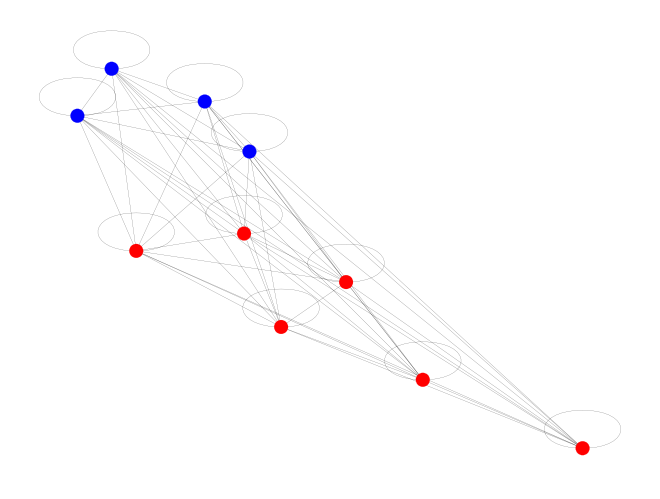

In [20]:
# spectral clustering
K = 2
clusters, _, _ = NormalizedSpectralClustering(Iss, K, verbose=False)

# convert adjacency matrix into graph
G = nx.from_numpy_matrix(Iss)

# display results
colors = []
for c in clusters :
    if c == 0 :
        colors.append('red')
    elif c == 1 :
        colors.append('blue')
nx.draw(G, linewidths=0.1, width=0.1, node_size=100, node_color=colors)

# check if clustering correct
true_labels = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
print("Rand Score:", metrics.adjusted_rand_score(true_labels, clusters))
print("Mutual Info Score:", metrics.adjusted_mutual_info_score(true_labels, clusters))
#print("Silhouette Score:", metrics.silhouette_score(np.fill_diagonal(Iss, 0), clusters, metric="precomputed"))

Compare to scikit's method for spectral clustering.

In [21]:
sc1 = cluster.SpectralClustering(2, affinity='precomputed')
sc1.fit(W_neurons)

sc2 = cluster.SpectralClustering(2, affinity='precomputed')
sc2.fit(Iss)

# check if clustering correct
true_labels = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
print("Wavelet Method Rand Score:", metrics.adjusted_rand_score(true_labels, sc1.labels_))
print("Wavelet Method Mutual Info Score:", metrics.adjusted_mutual_info_score(true_labels, sc1.labels_))
#print("Wavelet Silhouette Score:", metrics.silhouette_score(np.fill_diagonal(W_neurons, 0), sc1.labels_, metric="precomputed"))
print("Kernel Method Rand Score:", metrics.adjusted_rand_score(true_labels, sc2.labels_))
print("Kernel Method Mutual Info Score:", metrics.adjusted_mutual_info_score(true_labels, sc2.labels_))
#print("Kernel Silhouette Score:", metrics.silhouette_score(np.fill_diagonal(Iss, 0), sc2.labels_, metric="precomputed"))

Wavelet Method Rand Score: 0.3023255813953488
Wavelet Method Mutual Info Score: 0.2936670620608542
Kernel Method Rand Score: 1.0
Kernel Method Mutual Info Score: 1.0


## IV. Clustering on large scale neuron connections

Generate a large scale population of neurons with randomly generated dynamics. This is to test the real-world scenario of an analysis of a population of neurons in which we do not know their synaptic coupling and dynamics.

[Text(0.5, 1.0, 'Spike Train')]

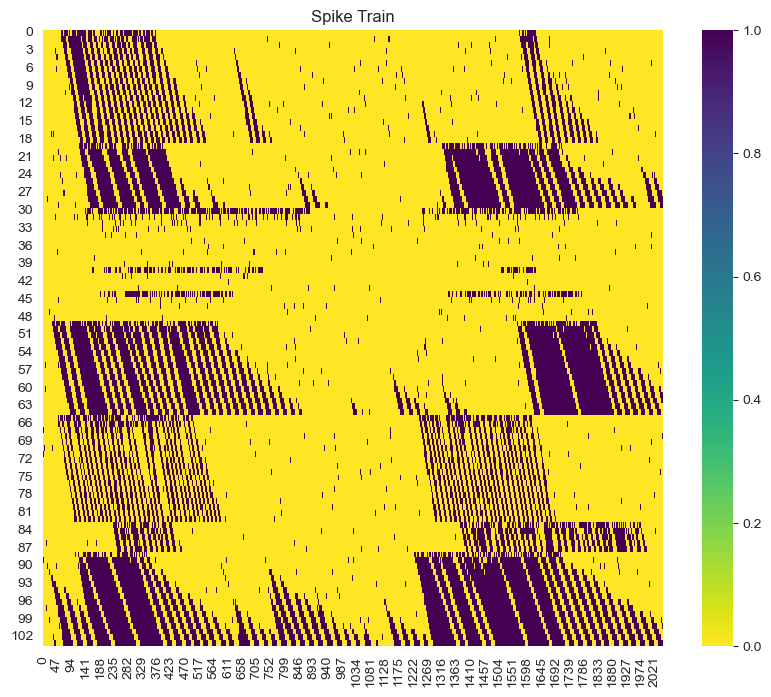

In [22]:
# neuron parameters
N = 2048  # bin count
delta = 0.01  # bin interval
K = np.random.randint(4, 10)  # number of clusters
low_cnt = 3  # lowest possible neuron count in cluster
high_cnt = 20  # highest possible neuron count in cluster
Mpq_low = 80  # lowest possible timescale
Mpq_high = 600  # highest possible timescale
prob_src_low = 0.5  # lowest possible probability of source firing
prob_src_high = 0.7  # highest possible probability of source firing
neuron_data = []  # holds info about data, used for verification
int1, int2, int3, int4, int5, int6 = 0, 300, 1000, 1200, 1600, 2000
P = 0

# generate population statistics
for k in range(K) :
    p = np.random.randint(low_cnt, high_cnt)
    Mpq = np.random.uniform(Mpq_low, Mpq_high)
    beta_src = np.log(np.random.uniform(prob_src_low, prob_src_high))
    firing_int = np.concatenate((np.arange(np.random.randint(int1, int2), np.random.randint(int2, int3)),
                                 np.arange(np.random.randint(int4, int5), np.random.randint(int5, int6))))
    P += p
    neuron_data.append((p, Mpq, beta_src, firing_int))
    
# define probability and spike train functions
lam_p = np.zeros((P, N))
s_p = np.zeros((P, N))

# generate spike trains and probabilities
neuron_cnt = 0
for k in range(K) :
    p, Mpq, beta_src, firing_int = neuron_data[k]
    # iterate through each neuron in population
    for i in range(p) :
        if (i == 0) :
            # generate source neuron
            lam_p[neuron_cnt, firing_int] = np.exp(beta_src)
            s_p[neuron_cnt, :] = generate_spiketrain(lam_p[neuron_cnt, :], N)
        else :
            # generate non-source neuron
            coeff = np.zeros(N)
            for n in range(N) :
                if (s_p[neuron_cnt - 1, n] == 1) :
                    interval = np.arange(n, N)
                    coeff[interval] += excitatory(Mpq, delta * (interval - n))
                lam_p[neuron_cnt, :] = np.exp(coeff)
                s_p[neuron_cnt, :] = generate_spiketrain(delta * lam_p[neuron_cnt, :], N)
        neuron_cnt += 1
        
# display raster plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(s_p, ax=ax, cmap='viridis_r')
ax.set(title='Spike Train')

Construct similarity matrix for spike train.

[Text(0.5, 1.0, 'Similarity Matrix')]

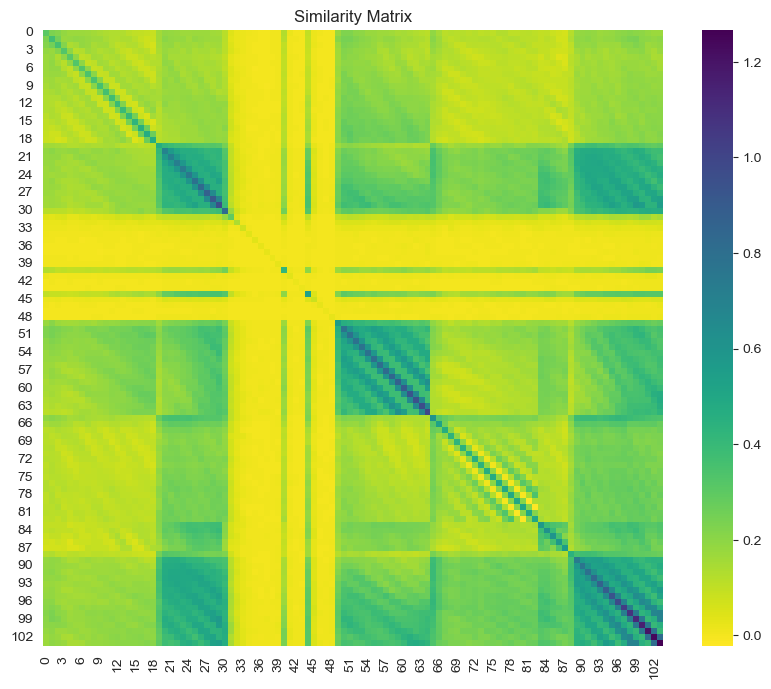

In [23]:
J = 2
Q = 2
W = SimilarityFromSpikeTrain(s_p, J, Q)

# display results
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(W, ax=ax, cmap='viridis_r')
ax.set(title='Similarity Matrix')

Perform exploratory data analysis to determine an optimal cluster amount.

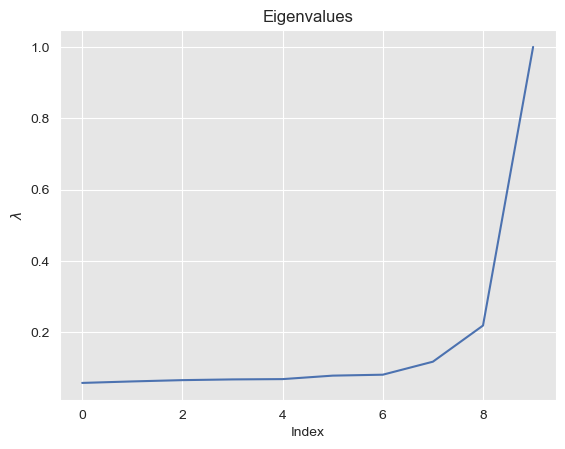

In [24]:
# Compute eigens
L = get_Lsym(W, verbose=False)
eigenvals, eigenvects = get_U(L, np.shape(L)[0], verbose=False, mode='max')

# show results
plt.figure()
plt.plot(eigenvals[-10:])
plt.xlabel('Index')
plt.ylabel('$\lambda$')
plt.title('Eigenvalues')
plt.show()

Perform hyperparameter tuning to select best model parameters.

In [25]:
# parameters
K = np.arange(3, 10)
J = np.arange(2, 9)
normalized = [True]
highest_rand, optimal_rand = -1, _
highest_mutual, optimal_mutual = -1, _
highest_silhouette, optimal_silhouette = -1, _
highest_avg, optimal_avg = -1, _
distortions = np.zeros((7, 7))
inertias = np.zeros((7, 7))

# get true cluster labels
cluster_cnts = [i[0] for i in neuron_data]
true_labels = []
for i in range(len(cluster_cnts)) :
    for j in range(cluster_cnts[i]) :
        true_labels.append(i)

# perform hyperparameter tuning
for k in K :
    for j in J :
        for n in normalized :
            # compute adjacency matrix
            W = SimilarityFromSpikeTrain(s_p, j, j)
            # fix numerical values
            np.fill_diagonal(W, 0)
            W[W < 0] = 0
            # perform spectral clustering
            if (n == True) :
                labels, dist, inert = NormalizedSpectralClustering(W, k, verbose=False, metrics=True)
                distortions[k - 3, j - 2] = dist
                inertias[k - 3, j - 2] = inert
            else :
                labels, dist, inert = SpectralClustering(W, k, verbose=False, metrics=True)
            # fix labels for silhouette score
            all_same = np.all(labels == labels[0])
            if (all_same == True) :
                labels[0] = labels[0] + 1
            # analyze results
            rand_score = metrics.adjusted_rand_score(true_labels, labels)
            mutual_score = metrics.adjusted_mutual_info_score(true_labels, labels)
            silhouette_score = metrics.silhouette_score(W, labels, metric='precomputed')
            avg_score = (rand_score + mutual_score) / 2
            # update optimal parameters
            if (rand_score > highest_rand) :
                highest_rand = rand_score
                optimal_rand = [k, j, j, n]
            if (mutual_score > highest_mutual) :
                highest_mutual = mutual_score
                optimal_mutual = [k, j, j, n]
            if (silhouette_score > highest_silhouette) :
                highest_silhouette = silhouette_score
                optimal_silhouette = [k, j, j, n]            
            if (avg_score > highest_avg) :
                highest_avg = avg_score
                optimal_avg = [k, j, j, n]

# print results
print("-------------------------------------------")
print("Optimal Parameters")
print("-------------------------------------------")
print("True K =", len(cluster_cnts))
print("Highest Rand Score:", highest_rand)
print("\tK =", optimal_rand[0])
print("\tJ =", optimal_rand[1])
print("\tQ =", optimal_rand[2])
print("\tNormalized =", optimal_rand[3])
print("Highest Mutual Score:", highest_mutual)
print("\tK =", optimal_mutual[0])
print("\tJ =", optimal_mutual[1])
print("\tQ =", optimal_mutual[2])
print("\tNormalized =", optimal_mutual[3])
print("Highest Silhouette Score:", highest_silhouette)
print("\tK =", optimal_silhouette[0])
print("\tJ =", optimal_silhouette[1])
print("\tQ =", optimal_silhouette[2])
print("\tNormalized =", optimal_silhouette[3])
print("Highest Average Score:", highest_avg)
print("\tK =", optimal_avg[0])
print("\tJ =", optimal_avg[1])
print("\tQ =", optimal_avg[2])
print("\tNormalized =", optimal_avg[3])

C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

-------------------------------------------
Optimal Parameters
-------------------------------------------
True K = 9
Highest Rand Score: 0.7977061064365615
	K = 8
	J = 8
	Q = 8
	Normalized = True
Highest Mutual Score: 0.838872640650644
	K = 8
	J = 8
	Q = 8
	Normalized = True
Highest Silhouette Score: -0.24544129125690453
	K = 8
	J = 2
	Q = 2
	Normalized = True
Highest Average Score: 0.8182893735436028
	K = 8
	J = 8
	Q = 8
	Normalized = True


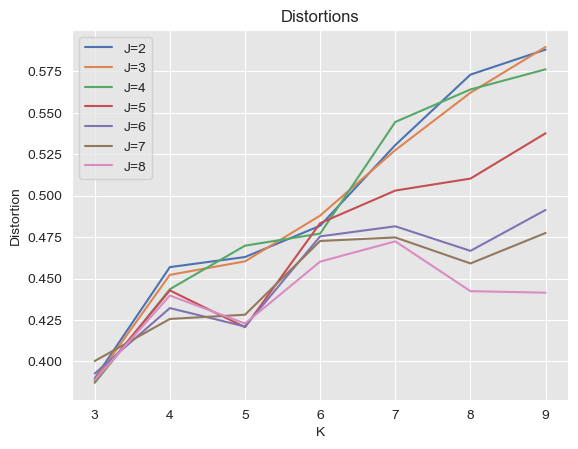

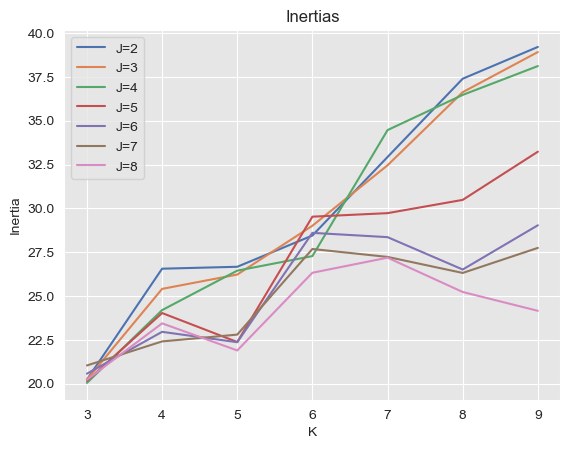

In [26]:
# plots for elbow method
plt.figure()
for i in range(7) :
    plt.plot(K, distortions[:, i], label="J={}".format(i+2))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Distortions')
plt.legend()
plt.show()

plt.figure()
for i in range(7) :
    plt.plot(K, inertias[:, i], label="J={}".format(i+2))
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertias')
plt.legend()
plt.show()

Perform hyperparameter tunin on several simulations to test validity of unsupervised methods.

In [27]:
#parameters
sim_cnt = 500
silhouettes = []
silhouettes_k = []
rands = []
rands_k = []
mutuals = []
mutuals_k = []
display_plots = False 
N = 2048  # bin count
delta = 0.01  # bin interval
low_cnt = 3  # lowest possible neuron count in cluster
high_cnt = 20  # highest possible neuron count in cluster
Mpq_low = 80  # lowest possible timescale
Mpq_high = 600  # highest possible timescale
prob_src_low = 0.5  # lowest possible probability of source firing
prob_src_high = 0.7  # highest possible probability of source firing
int1, int2, int3, int4, int5, int6 = 0, 300, 1000, 1200, 1600, 2000

# perform simulations
for sim_num in range(sim_cnt) :
    print("Running simulation", sim_num+1, "/", sim_cnt)
    # parameters
    K = np.random.randint(4, 10)  # number of clusters
    neuron_data = []  # holds info about data, used for verification
    P = 0
        # generate population statistics
    for k in range(K) :
        p = np.random.randint(low_cnt, high_cnt)
        Mpq = np.random.uniform(Mpq_low, Mpq_high)
        beta_src = np.log(np.random.uniform(prob_src_low, prob_src_high))
        firing_int = np.concatenate((np.arange(np.random.randint(int1, int2), np.random.randint(int2, int3)),
                                     np.arange(np.random.randint(int4, int5), np.random.randint(int5, int6))))
        P += p
        neuron_data.append((p, Mpq, beta_src, firing_int))
    # define probability and spike train functions
    lam_p = np.zeros((P, N))
    s_p = np.zeros((P, N))
    # generate spike trains and probabilities
    neuron_cnt = 0
    for k in range(K) :
        p, Mpq, beta_src, firing_int = neuron_data[k]
        # iterate through each neuron in population
        for i in range(p) :
            if (i == 0) :
                # generate source neuron
                lam_p[neuron_cnt, firing_int] = np.exp(beta_src)
                s_p[neuron_cnt, :] = generate_spiketrain(lam_p[neuron_cnt, :], N)
            else :
                # generate non-source neuron
                coeff = np.zeros(N)
                for n in range(N) :
                    if (s_p[neuron_cnt - 1, n] == 1) :
                        interval = np.arange(n, N)
                        coeff[interval] += excitatory(Mpq, delta * (interval - n))
                    lam_p[neuron_cnt, :] = np.exp(coeff)
                    s_p[neuron_cnt, :] = generate_spiketrain(delta * lam_p[neuron_cnt, :], N)
            neuron_cnt += 1
    
    # hyperparameter tuning
    K = np.arange(3, 10)
    J = np.arange(5, 9)
    normalized = [True]
    highest_rand, optimal_rand = -1, _
    highest_mutual, optimal_mutual = -1, _
    highest_silhouette, optimal_silhouette = -1, _
    distortions = np.zeros((7, 4))
    inertias = np.zeros((7, 4))
    # get true cluster labels
    cluster_cnts = [i[0] for i in neuron_data]
    true_labels = []
    for i in range(len(cluster_cnts)) :
        for j in range(cluster_cnts[i]) :
            true_labels.append(i)
    # perform hyperparameter tuning
    for k in K :
        for j in J :
            for n in normalized :
                # compute adjacency matrix
                W = SimilarityFromSpikeTrain(s_p, j, j)
                # fix numerical values
                np.fill_diagonal(W, 0)
                W[W < 0] = 0
                # perform spectral clustering
                if (n == True) :
                    if (display_plots == True) :
                        labels, dist, inert = NormalizedSpectralClustering(W, k, verbose=False, metrics=True)
                    else :
                        labels, dist, inert = NormalizedSpectralClustering(W, k, verbose=False)
                    distortions[k - 3, j - 5] = dist
                    inertias[k - 3, j - 5] = inert
                else :
                    if (display_plots == True) :
                        labels, dist, inert = SpectralClustering(W, k, verbose=False, metrics=True)
                    else :
                        labels, dist, inert = NormalizedSpectralClustering(W, k, verbose=False)
                # fix labels for silhouette score
                all_same = np.all(labels == labels[0])
                if (all_same == True) :
                    labels[0] = labels[0] + 1
                # analyze results
                rand_score = metrics.adjusted_rand_score(true_labels, labels)
                mutual_score = metrics.adjusted_mutual_info_score(true_labels, labels)
                silhouette_score = metrics.silhouette_score(W, labels, metric='precomputed')
                # update optimal parameters
                if (rand_score > highest_rand) :
                    highest_rand = rand_score
                    optimal_rand = [k, j, j, n]
                if (mutual_score > highest_mutual) :
                    highest_mutual = mutual_score
                    optimal_mutual = [k, j, j, n]
                if (silhouette_score > highest_silhouette) :
                    highest_silhouette = silhouette_score
                    optimal_silhouette = [k, j, j, n]
    
    # display results
    true_K = len(cluster_cnts)
    if (display_plots == True) :
        plt.figure()
        for i in range(4) :
            plt.plot(K, distortions[:, i], label="J={}".format(i+2))
        plt.xlabel('K')
        plt.ylabel('Distortion')
        plt.title('Distortions Sim {} K={}'.format(sim_num, true_K))
        plt.legend()
        plt.show()
        plt.figure()
        for i in range(4) :
            plt.plot(K, inertias[:, i], label="J={}".format(i+2))
        plt.xlabel('K')
        plt.ylabel('Inertia')
        plt.title('Inertias Sim {} K={}'.format(sim_num, true_K))
        plt.legend()
        plt.show()
    
    # save statistics
    rands.append(highest_rand)
    mutuals.append(highest_mutual)
    silhouettes.append(highest_silhouette)
    rands_k.append(optimal_rand[0] - true_K)
    mutuals_k.append(optimal_mutual[0] - true_K)
    silhouettes_k.append(optimal_silhouette[0] - true_K)

Running simulation 1 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 2 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 3 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 4 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 5 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 6 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 7 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 8 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 9 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 10 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 11 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 12 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 13 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 14 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 15 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 16 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 17 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 18 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 19 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 20 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 21 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 22 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 23 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 24 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 25 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 26 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 27 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 28 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 29 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 30 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 31 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 32 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 33 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 34 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 35 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 36 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 37 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 38 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 39 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 40 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 41 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 42 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 43 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 44 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 45 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 46 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 47 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 48 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 49 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 50 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 51 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 52 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 53 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 54 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 55 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 56 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 57 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 58 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 59 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 60 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 61 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 62 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 63 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 64 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 65 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 66 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 67 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 68 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 69 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 70 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 71 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 72 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 73 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 74 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 75 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 76 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 77 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 78 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 79 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 80 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 81 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 82 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 83 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 84 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 85 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 86 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 87 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 88 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 89 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 90 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 91 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 92 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 93 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 94 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 95 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 96 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 97 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 98 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 99 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 100 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 101 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 102 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 103 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 104 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 105 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 106 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 107 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 108 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 109 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 110 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 111 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 112 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 113 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 114 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 115 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 116 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 117 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 118 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 119 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 120 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 121 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 122 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 123 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 124 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 125 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 126 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 127 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 128 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 129 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 130 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 131 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 132 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 133 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 134 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 135 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 136 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 137 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 138 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 139 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 140 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 141 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 142 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 143 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 144 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 145 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 146 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 147 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 148 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 149 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 150 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 151 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 152 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 153 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 154 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 155 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 156 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 157 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 158 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 159 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 160 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 161 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 162 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 163 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 164 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 165 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 166 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 167 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 168 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 169 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 170 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 171 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 172 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 173 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 174 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 175 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 176 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 177 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 178 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 179 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 180 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 181 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 182 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 183 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 184 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 185 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 186 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 187 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 188 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 189 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 190 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 191 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 192 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 193 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 194 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 195 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 196 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 197 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 198 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 199 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 200 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 201 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 202 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 203 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 204 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 205 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 206 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 207 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 208 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 209 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 210 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 211 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 212 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 213 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 214 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 215 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 216 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 217 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 218 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 219 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 220 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 221 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 222 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 223 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 224 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 225 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 226 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 227 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 228 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 229 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 230 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 231 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 232 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 233 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 234 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 235 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 236 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 237 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 238 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 239 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 240 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 241 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 242 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 243 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 244 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 245 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 246 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 247 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 248 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 249 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 250 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 251 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 252 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 253 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 254 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 255 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 256 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 257 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 258 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 259 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 260 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 261 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 262 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 263 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 264 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 265 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 266 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 267 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 268 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 269 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 270 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 271 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 272 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 273 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 274 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 275 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 276 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 277 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 278 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 279 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 280 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 281 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 282 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 283 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 284 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 285 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 286 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 287 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 288 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 289 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 290 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 291 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 292 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 293 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 294 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 295 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 296 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 297 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 298 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 299 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 300 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 301 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 302 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 303 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 304 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 305 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 306 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 307 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 308 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 309 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 310 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 311 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 312 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 313 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 314 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 315 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 316 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 317 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 318 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 319 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 320 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 321 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 322 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 323 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 324 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 325 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 326 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 327 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 328 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 329 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 330 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 331 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 332 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 333 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 334 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 335 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 336 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 337 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 338 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 339 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 340 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 341 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 342 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 343 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 344 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 345 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 346 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 347 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 348 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 349 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 350 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 351 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 352 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 353 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 354 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 355 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 356 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 357 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 358 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 359 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 360 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 361 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 362 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 363 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 364 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 365 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 366 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 367 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 368 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 369 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 370 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 371 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 372 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 373 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 374 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 375 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 376 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 377 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 378 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 379 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 380 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 381 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 382 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 383 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 384 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 385 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 386 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 387 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 388 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 389 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 390 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 391 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 392 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 393 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 394 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 395 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 396 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 397 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 398 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 399 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 400 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 401 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 402 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 403 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 404 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 405 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 406 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 407 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 408 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 409 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 410 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 411 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 412 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 413 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 414 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 415 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 416 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 417 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 418 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 419 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 420 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 421 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 422 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 423 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 424 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 425 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 426 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 427 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 428 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 429 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 430 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 431 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 432 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 433 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 434 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 435 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 436 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 437 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 438 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 439 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 440 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 441 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 442 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 443 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 444 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 445 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 446 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 447 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 448 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 449 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 450 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 451 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 452 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 453 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 454 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 455 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 456 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 457 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 458 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 459 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 460 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 461 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 462 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 463 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 464 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 465 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 466 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 467 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 468 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 469 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 470 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 471 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 472 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 473 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 474 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 475 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 476 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 477 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 478 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 479 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 480 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 481 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 482 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 483 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 484 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 485 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 486 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 487 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 488 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 489 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 490 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 491 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 492 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 493 / 500
Running simulation 494 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 495 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 496 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Running simulation 497 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 498 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 499 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

Running simulation 500 / 500


C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacks\anaconda3\envs\mne\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C

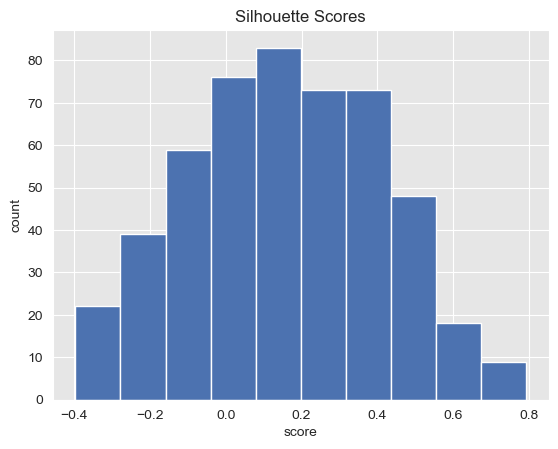

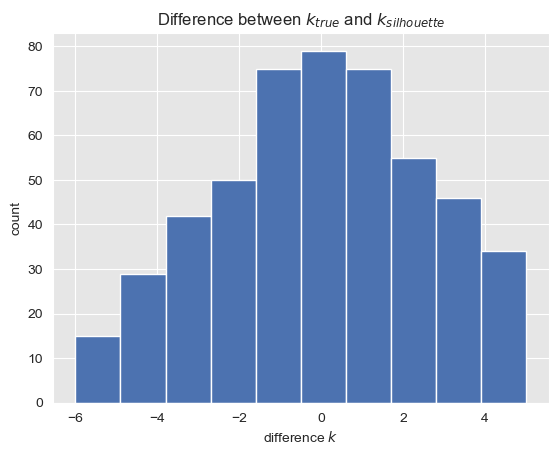

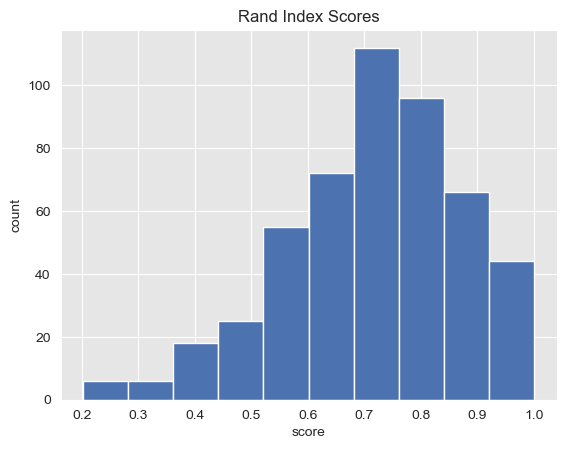

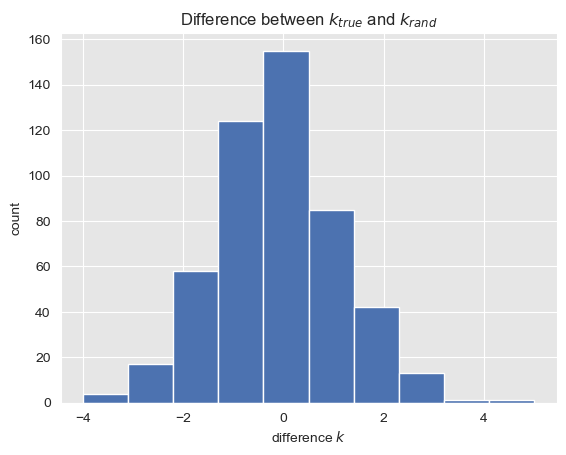

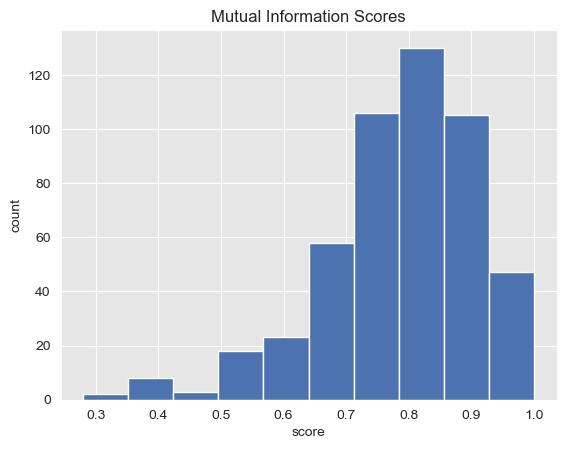

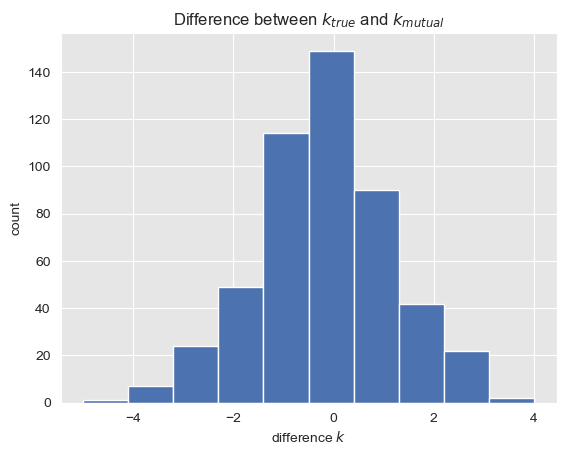

Average Silhouette Score: 0.15828954410313043
Std Dev Silhouette Score: 0.25560281005211727
Average Silhouette Score Difference: -0.058
Std Dev Silhouette Score Difference: 2.3997158165082797
Average Silhouette Score: 0.7152621418244298
Std Dev Silhouette Score: 0.1582921759727694
Average Silhouette Score Difference: -0.18
Std Dev Silhouette Score Difference: 1.3912584231550944
Average Silhouette Score: 0.78629503176352
Std Dev Silhouette Score: 0.12431829702763948
Average Silhouette Score Difference: -0.138
Std Dev Silhouette Score Difference: 1.510945399410581


In [30]:
# display results
plt.hist(silhouettes)
plt.title('Silhouette Scores')
plt.xlabel('score')
plt.ylabel('count')
plt.show() 
plt.hist(silhouettes_k)
plt.title('Difference between $k_{true}$ and $k_{silhouette}$')
plt.xlabel('difference $k$')
plt.ylabel('count')
plt.show()

plt.hist(rands)
plt.title('Rand Index Scores')
plt.xlabel('score')
plt.ylabel('count')
plt.show() 
plt.hist(rands_k)
plt.title('Difference between $k_{true}$ and $k_{rand}$')
plt.xlabel('difference $k$')
plt.ylabel('count')
plt.show()

plt.hist(mutuals)
plt.title('Mutual Information Scores')
plt.xlabel('score')
plt.ylabel('count')
plt.show() 
plt.hist(mutuals_k)
plt.title('Difference between $k_{true}$ and $k_{mutual}$')
plt.xlabel('difference $k$')
plt.ylabel('count')
plt.show()

print('Average Silhouette Score:', np.mean(silhouettes))
print('Std Dev Silhouette Score:', np.std(silhouettes))
print('Average Silhouette Score Difference:', np.mean(silhouettes_k))
print('Std Dev Silhouette Score Difference:', np.std(silhouettes_k))

print('Average Silhouette Score:', np.mean(rands))
print('Std Dev Silhouette Score:', np.std(rands))
print('Average Silhouette Score Difference:', np.mean(rands_k))
print('Std Dev Silhouette Score Difference:', np.std(rands_k))

print('Average Silhouette Score:', np.mean(mutuals))
print('Std Dev Silhouette Score:', np.std(mutuals))
print('Average Silhouette Score Difference:', np.mean(mutuals_k))
print('Std Dev Silhouette Score Difference:', np.std(mutuals_k))